Adapted by Carlos Toxtli https://www.carlostoxtli.com/#ranfor-4

Source: https://github.com/hvantil/RandomForestTutorial/blob/master/RandomForestTutorial.ipynb

In [ ]:
!git clone https://github.com/hvantil/RandomForestTutorial.git
%cd RandomForestTutorial

Cloning into 'RandomForestTutorial'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Unpacking objects: 100% (17/17), done.
/content/RandomForestTutorial


# Random Forest Classifer Tutorial

![](https://www.researchgate.net/profile/Evaldas_Vaiciukynas/publication/301638643/figure/fig1/AS:355471899807744@1461762513154/Architecture-of-the-random-forest-model.png)

## Contents

1. [Introduction](#intro)
2. [Decision Trees](#dt)
	- [Background](#bg)
	- [Representing Rules as Nodes](#nodes)
	- [Learning Decision Tree Models](#learning)
	- [Decision Tree Class](#dt_class)
	- [Example: XOR](#dt_xor)
	- [Example: Abalone Age Prediction](#dt_abalone)
3. [Random Forests](#rf)
	- [Stochastic Feature Selection](#stoch)
	- [Random Forest Class](#rf_class)
	- [Example: XOR](#rf_xor)
	- [Example: Abalone Age Prediction](#rf_abalone)
4. [Random Forests in Scikit-Learn](#skl_rf)

<a id='intro'></a>
## 1. Introduction

This tutorial walks through the implementation of a random forest classifier and applies it to a well known dataset. Random forests are a type of ensemble method, meaning they use an "average" of many base models to form a single, more accurate model. When the base model is a decision tree, the ensemble method is known as a random forest.

Since random forests are based on decision trees, this tutorial will first walkthrough the implementation of a decision tree classifier. The limitations of decision trees will be discussed, and then a random forest classifier will be implemented to show how it overcomes these. Finally, the performance of this tutorial's random forest implementation will be compared against an optimzed implementation from the scikit-learn library on an example dataset.

<a id='dt'></a>
## 2. Decision Trees

<a id='bg'></a>
### Background

Decision trees classify data as a top-down flow chart. To make predictions from unseen examples, simply trace a path down the tree by following the conditions at each node, eventually arriving at a leaf containing the predicted label. Decision trees are considered one of the most interpretable machine learning models because of this simple intuition. In general, decision trees can handle both classification and regression, as well as both continous and categorical features. For simplicity, this tutorial focuses on classification tasks with purely continous features. [One-hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) can be used to include discrete features from a dataset as continous features in a model. Below is an example of a decision tree which shows the probability of a passenger surviving on the Titanic (decimal shows the probability, percentage shows the number of samples in that leaf).

 <img src="https://upload.wikimedia.org/wikipedia/commons/6/6b/Titanic_Survival_Decison_Tree_SVG.png" width="450"> 

<a id='nodes'></a>
### Representing Rules as Nodes

In this tutorial, a decision tree classifier is implemented as a Python class, with an interface similar to that of scikit-learn. The usage is to create a DecisionTree object, fit a model with training data, and predict class labels for test data. The decision rules are stored as a binary tree, where each internal node represents a rule to split the data on and each leaf node represents a class label prediction. Internal nodes store what feature they are splitting on (represented by a column of the training data), what value is being tested to split on that feature, and pointers to its respective child nodes if the decision rule evaluates true or false. Leaf nodes only need to store a class label prediction. Below, a DecisionNode class is implemented which meets these requirements. 

In [ ]:
class DecisionNode:
    """ Decision node for decision tree classification models.
        Attributes:
            col (int) : column index, corresponding to what feature to split on
            val (float) : value to test split against
            child_t (DecisionNode) : node to traverse to if sample evaulates true
            child_f (DecisionNode) : node to traverse to if sample evaulates false
            label (int) : predicted class label
    """
    
    def __init__(self):
        """ Initialize a decision node."""
        self.col = None
        self.val = None
        self.child_t = None
        self.child_f = None
        self.label = None
    
    def is_leaf(self):
        """ Check if decision node is leaf.
            Return:
                (bool) : True if is leaf, else False
        """
        if self.label == None:
            return False
        return True

<a id='learning'></a>
### Learning Decision Tree Models

Typically a machine learning model is defined mathematically as a hypothesis function which depends on some set of parameters, and the optimal values for these parameters are found by minimizing some loss function. While a decision tree is easy to interpret in layman's terms, it is not straightforward to represent mathematically. Gradient descent couldn't be used to minimize a loss function as there is no concept of a gradient for a discrete structure like a tree. Brute force computation of a loss function for all possible trees would be impossible; a dataset with only 6 features has over $10^{19}$ possible trees. Instead, a heuristic approach is used which greedily chooses the best decision rule at each step of tree growth until some stopping criteria is met. The best decision rule is determined by a loss function which measures the "purity" of a data split. Both [Information Gain](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) and [Gini Impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) provide similar measures of the "purity" of a data split, but Gini Impurity is preferred as it doesn't require the computation of a log. The Gini Impurity for a group of data is given by the following equation, where $p_i$ is the proportion of samples with class label $i$.

$$ G = \sum_{i=1}^{J} p_i \left(1-p_i\right) = 1 - \sum_{i=1}^{J} p_i^2 $$

To compute a loss function for each potential data split, we take a weighted sum of the Gini Impurity from the "true" group and the "false" group. Below is the equation for and implementation of this loss function. 

$$ L(d_T, d_F) = \frac{n_T}{n_T+n_F} G(d_T) +  \frac{n_F}{n_T+n_F} G(d_F)$$

In [ ]:
import numpy as np

def gini(d1, d2):
    """ Loss function for determining best decision rule when growing 
        decision trees, based on the Gini Impurity.        
        Args:
            d1 (array like) : vector of class labels for data group 1
            d2 (array like) : vector of class labels for data group 2
        Return:
            (float) : loss value
    """
    
    n1, n2 = d1.shape[0], d2.shape[0]
    g1 = 1 - np.sum((np.unique(d1, return_counts=True)[1] / n1)**2)
    g2 = 1 - np.sum((np.unique(d2, return_counts=True)[1] / n2)**2)
    return (g1*n1 + g2*n2) / (n1 + n2)


### 2 examples showing the data split loss function, based on Gini Impurity

# data is perfectly split by class label
yt, yf = np.array([1, 1]), np.array([0, 0])
print('gini loss, "pure" data split:', gini(yt, yf))

# data is completely mixed by class label
yt, yf = np.array([0, 1]), np.array([0, 1])
print('gini loss, "bad" data split:', gini(yt, yf))

gini loss, "pure" data split: 0.0
gini loss, "bad" data split: 0.5


Finding the best decision rule is a matter of minimizing the data split loss over all possible decision rules. A decision rule is defined by a feature to test and a value to test against. The split values considered for each feature are the midpoints between every value of that feature. Computing the midpoints requires first sorting the unique feature values, then taking the average between each sorted value. The function below finds the best decision rule by iterating over all possible features and values, and keeping track of the decision rule with the lowest data split loss. 

In [ ]:
def best_split(data, loss_fxn):
    """ Given a set of training data and a loss function, determines the best feature 
        to split on and best value to test on for growing a decision tree. 
        Args:
            data (np array) : array of training data with class labels as last column
            loss_fxn (function) : python function for computing data split loss        
        Return:
            (int) : best column to split on
            (float) :  best value to test on
            (np array) : data subset that evaluates true
            (np array) : data subset that evaluates false                    
    """
    
    class_vals = np.unique(data[:,-1])
    b_loss = float('Inf')
    b_col = b_val = None
    b_data_t = b_data_f = np.array([])

    for col in range(data.shape[1]-1):
        feature_vals = np.sort(np.unique(data[:,col]))
        midpoints = (feature_vals[1:] + feature_vals[:-1]) / 2.

        for val in midpoints:
            data_t = data[data[:,col] < val]
            data_f = data[data[:,col] >= val]
            loss = loss_fxn(data_t[:,-1], data_f[:,-1])
            if loss < b_loss:
                b_loss, b_col, b_val, b_data_t, b_data_f = loss, col, val, data_t, data_f

    return (b_col, b_val, b_data_t, b_data_f)


### example of finding best feature and value to split data on
X = np.array([[1,7], [1,3], [-1,4], [-1,6]])
y = np.array([0,0,1,1])
print('  X1, X2, y\n',np.c_[X,y],'\n')
col, val, data_t, data_f = best_split(np.c_[X, y], gini)
print('Best split on X{} < {}\n'.format(col+1, val))
print('Subset of data where rule is true:\n', data_t)
print('Subset of data where rule is false:\n', data_f)

  X1, X2, y
 [[ 1  7  0]
 [ 1  3  0]
 [-1  4  1]
 [-1  6  1]] 

Best split on X1 < 0.0

Subset of data where rule is true:
 [[-1  4  1]
 [-1  6  1]]
Subset of data where rule is false:
 [[1 7 0]
 [1 3 0]]


<a id='dt_class'></a>
### Decision Tree Class

To learn a full tree model, child nodes are recursively created from the root down until a stopping criteria is met. In this implementation, the tree model stops growing and creates a leaf in two cases: if adding a new decision rule would surpass a specified maximum tree depth, or if all class labels in the data subset for that node are the same (i.e. further splitting is meaningless, the predicted class label is already known). A decision tree classifier class is implemented below which includes the before mentioned data split loss, best split function, and stopping criteria. Additionally, this class has methods to traverse a learned tree model and make class label predictions for unseen data.

In [ ]:
class DecisionTree:
    """ Build decision tree classification model and predict class labels on unseen examples.
        Attributes:
            max_depth (int) : maximum depth tree is allowed to grow to
            loss_fxn (funtion) : function for evaluating data split loss
            split_fxn (function) : function for determing best feature and value to split on
            root (DecisionNode) : root of learned decision tree model            
    """
    
    def __init__(self, max_depth=float('Inf'), loss=gini, split=best_split):
        """ Initialize a decision tree classifier model.
            Args:
                max_depth (int) : (optional) maximum depth tree is allowed to grow to
                loss (function) : (optional) function for evaluating data split loss
                split (function) : (optional) function for determining best feature and value to split on
        """
        self.max_depth = max_depth
        self.loss_fxn = loss
        self.split_fxn = split
        self.root = None   
    
    def fit(self, X, y):
        """ Fit a decision tree classification model to training data.
            Args:
                X (np array) : array of training data, n_samples x n_features
                y (array like) : vector of class labels, n_samples
        """
        self.root = self.add_child(np.c_[X, y], 0)
    
    def predict(self, X):
        """ Predict class labels for unseen examples.
            Args:
                X (np array) : array of test data, n_samples x n_features
            Return:
                (np array) : vector of predicted class labels
        """
        y = np.array([self.node_search(self.root, row) for row in X])
        return y
    
    def add_child(self, data, depth):
        """ Add a child node to a decision tree, called recursively.
            Args:
                data (np array) : array of training data with class labels as last column
                depth (int) : current depth in tree
            Return:
                (DecisionNode or None) : DecisionNode of child to add to tree, None if no data passed in
        """
        if data.shape[0]==0:
            return None
        if depth >= self.max_depth:
            return self.make_leaf(data)

        col, val, data_t, data_f = self.split_fxn(data, self.loss_fxn)
        child_t = self.add_child(data_t, depth+1)
        child_f = self.add_child(data_f, depth+1)
        
        if (child_t == None) and (child_f != None):
            return self.make_leaf(data_f)
        if (child_f == None) and (child_t != None):
            return self.make_leaf(data_t)
        if (child_t == None) and (child_f == None):
            return self.make_leaf(data)

        node = DecisionNode()
        if child_t.is_leaf() and child_f.is_leaf() and child_t.label==child_f.label:
            node.label = child_t.label
        else:
            node.col, node.val, node.child_t, node.child_f = col, val, child_t, child_f
        return node 
    
    def make_leaf(self, data):
        """ Makes a leaf decision node, with predicted class label as mode of example labels.
            Args:
                data (np array) : array of training data with class labels as last column
            Return:
                (DecisionNode) : leaf node
        """
        labels = data[:,-1].tolist()
        node = DecisionNode()
        node.label = max(set(labels), key=labels.count)
        return node
    
    def node_search(self, node, sample):
        """ Traverse decision tree by evaluating samples at each node, called recursively.
            Args:
                node (DecisionNode) : decision node containing decision criteria, or class label if leaf
                sample (array like) : vector of feature values
            Return: 
                (int) : predicted class label
        """
        if node.is_leaf():
            return node.label
            
        if sample[node.col] < node.val:
            return self.node_search(node.child_t, sample)
        else:
            return self.node_search(node.child_f, sample)           

In addition to the class definition, two helper functions are defined below. The first prints the decision nodes and predicted class labels for a decision tree, and the second computes the accuracy of a model given a set of test samples.

In [ ]:
def print_tree(node, depth=0, flag=0):
    """ Prints a decision tree, displaying decision rules and class labels, called recursively.
        Args:
            node (DecisionNode) : current decision node
            depth (int) : current tree depth
            flag (int) : 0=root, 1=True, 2=False
    """
    if flag==1:
        prefix = 'T->'
    elif flag==2:
        prefix = 'F->'
    else:
        prefix = ''

    if node.is_leaf():
        print('{}{}[{}]'.format(depth*'   ', prefix, node.label))
    else:  
        print('{}{}(X{} < {:0.3f})?'.format(depth*'   ', prefix, node.col+1, node.val))
        print_tree(node.child_t, depth+1, 1)
        print_tree(node.child_f, depth+1, 2)
        
        
def accuracy(model, X_test, y_test):
    """ Computes the accuracy of a given model as the percentage of correctly classified examples.
        Args:
            model (model like) : trained classification model to be evaluated
            X_test (np array) : test data, n_samples x n_features
            y_test (array like) : true class labels, n_samples
        Return:
            (float) : accuracy of classification model in range [0.0, 1.0]
    """
    predictions = model.predict(X_test)
    return (np.array(predictions) == np.array(y_test)).mean()

<a id='dt_xor'></a>
### Example: XOR

First, let's test our decision tree class on a simple example. Here we use a contrived dataset of four samples which represent an "exclusive or" function. A plot of this dataset is shown below.

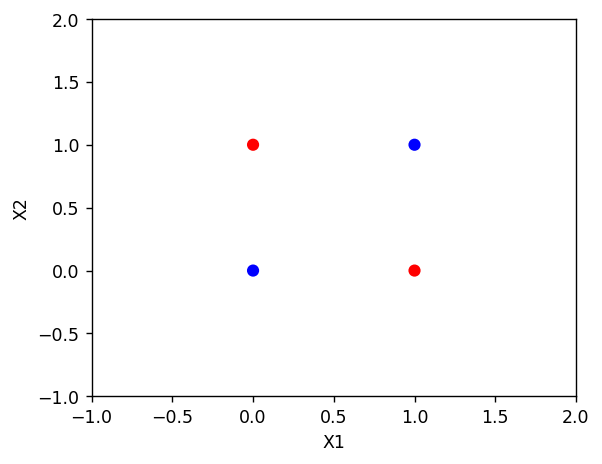

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

X = np.array([[0,0], [0,1], [1,0], [1,1]])
y = np.array([0, 1, 1, 0])

f, ax = plt.subplots(figsize=(5,4), dpi=125)
ax.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
ax.axis([-1, 2, -1, 2]); ax.set_xlabel('X1'); ax.set_ylabel('X2');

Although this appears to be a simple binary classification problem, it would be impossible to fit a linear model through these data points without engineering new features. Yet, it's not difficult to come up with a set of decision rules to perfectly classify these points by hand. Let's try it out on our decision tree class.

In [ ]:
tree = DecisionTree()
tree.fit(X, y)

print_tree(tree.root)

(X1 < 0.500)?
   T->(X2 < 0.500)?
      T->[0]
      F->[1]
   F->(X2 < 0.500)?
      T->[1]
      F->[0]


Looks good! Our decision tree class grew a tree of depth two, spliting the data how you would expect. To get a better understanding of what types of models decision trees produce, let's make a function that plots colored regions to show what class the model would predict for various feature values.

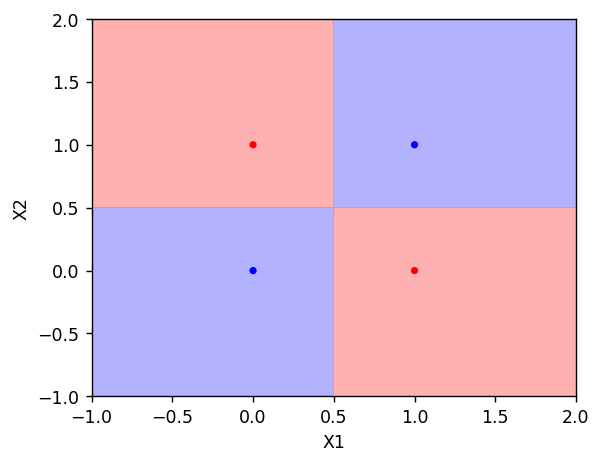

In [ ]:
def visualize_xor_classifier(model, X, y):
    """ Visualize decisision boundaries, hard-coded for the XOR example problem.
        Args:
            model (decision tree like) : classification model object
            X (np array) : array of training data, n_samples x n_features
            y (array like) : vector of class labels, n_samples            
    """
    xx, yy = np.meshgrid(np.linspace(-1,2,200), np.linspace(-1,2,200))
    samples = (np.c_[xx.ravel(), yy.ravel()]).tolist()
    Z = (np.array(model.predict(samples))).reshape(xx.shape)

    f, ax = plt.subplots(figsize=(5,4), dpi=125)
    ax.scatter(X[:,0], X[:,1], c=y, zorder=3, cmap='bwr', s=10)
    ax.contourf(xx, yy, Z, alpha=0.6, levels=[-.5,.5,1.5], zorder=1, cmap='bwr');
    ax.axis([-1, 2, -1, 2]); ax.set_xlabel('X1'); ax.set_ylabel('X2')
    
    
visualize_xor_classifier(tree, X, y)

Decision trees make a series of axis aligned linear decision boundaries. That is, each decision rule linearly splits the data at that node into two subsets. In two dimensions this produces a collection of rectangle-shaped decision boundaries, in higher dimensions this produces a collection of hyper-cubes representing respective class predictions. While this model works well on simple datasets like the one above, it tends to perform poorly on noisy data. Let's look at a more complex version of the XOR example, now using noisy data centered around the original points.

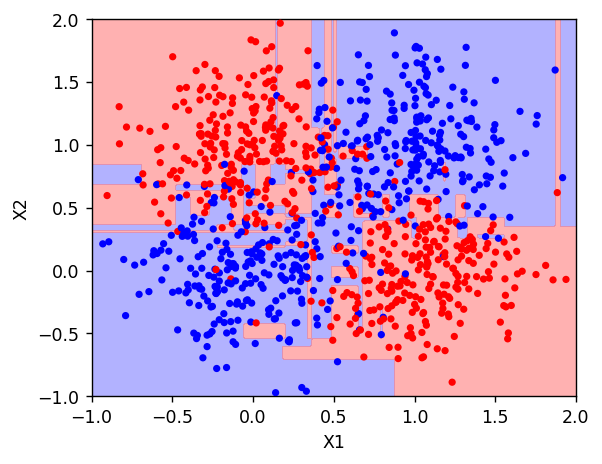

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, cluster_std=[.35]*4, random_state=0,
                  centers=[[0, 0],[0, 1],[1, 0],[1, 1]])
y[y==3] = 0
y[y==2] = 1

tree = DecisionTree()
tree.fit(X, y)
visualize_xor_classifier(tree, X, y)

The resulting decision boundaries don't appear to model the underlying distribution well. It appears that the model tried too hard to achieve low error on this training set, and likely wouldn't generalize well to another sample of data drawn from the same distribution. This is known as overfitting, and is a common problem with decision trees.

<a id='dt_abalone'></a>
### Example: Abalone Age Prediction

For a more in depth example, we'll analyze a dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/abalone) which is used for predicting the age of abalone (marine snails) from physical measurements. The data contains 1 categorical feature (converted to one-hot encoding) and 7 continous features. The original data contains 28 class labels which correspond to the age of the abalone. To make this into a simpler problem, the original 28 class labels are reduced into three class labels of roughly equal size. One could think of the new labels as "young", "adult", and "old". 

In [ ]:
import csv

X = []
y = []

lims = [0,8,12,30]
def reduce(a):
    for i in range(len(lims)-1):
        if a>=lims[i] and a<lims[i+1]:
            return i

with open('abalone.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:   
        if row[0]=='M':
            c = [0, 0, 1]
        elif row[0]=='F':
            c = [0, 1, 0]
        else:
            c = [1, 0, 0]
            
        X.append(c + [float(row[i]) for i in range(1, len(row)-1)]) 
        y.append(reduce(int(row[-1])))

X, y = np.array(X), np.array(y)

To evaluate the accuracy of the model, 70% of the dataset is used for training while 30% is kept for testing. The "train_test_split" utility function from scikit-learn is used to easily split the data into training and test sets. A set of decision tree classifiers is trained with varying depth, and the results are plotted below.

Best Test Accuracy: 0.746


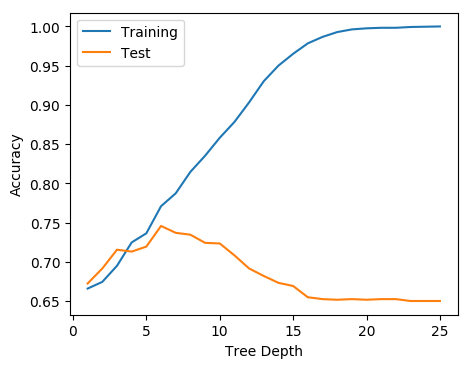

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

depth = np.arange(1,26)
acc_train = []
acc_test = []
for d in depth:
    tree = DecisionTree(max_depth=d)
    tree.fit(X_train, y_train)
    acc_train.append(accuracy(tree, X_train, y_train))
    acc_test.append(accuracy(tree, X_test, y_test))

dt_acc = np.array(acc_test).max()
print('Best Test Accuracy: {:0.3f}'.format(dt_acc))

f, ax = plt.subplots(figsize=(5,4), dpi=100)
ax.plot(depth, acc_train, label='Training')
ax.plot(depth, acc_test, label='Test')
ax.set_xlabel('Tree Depth'); ax.set_ylabel('Accuracy'); ax.legend();

We see that as tree depth grows, the training accuracy eventually converges to 1.0 while the test accuracy actually begins to decrease for trees of depth greather than 7. This is a clear example of overfitting. To overcome this problem, a random forest classifier will be used.

<a id='rf'></a>
## 3. Random Forests

Random forests are an ensemble machine learning model made up of a collection of decision trees. The idea is to train many slighty different decision tree models, and then take a majority vote from the collection of trees to make class label predictions. We've seen that decision trees have a tendency to overfit their training data, which also corresponds to a model with low bias and high variance. "Averaging" many different trees together can significantly reduce the variance of the model, which leads to higher accuracy on unseen data ([more](https://en.wikipedia.org/wiki/Random_forest)).

<a id='stoch'></a>
### Stochastic Feature Selection

To grow a collection of different decision trees, two elements of randomness are introduced. First, each tree in the model is trained on a random sample of the original data. Typically, the random samples are the same size as the original dataset, but are drawn with replacement. This is known as bootstrap aggregating, or bagging. Second, at each step of choosing the best decision rule, the tree is only allowed to select from a random subset of the available features. A general rule of thumb is if the full data has $n$ features, $\sqrt{n}$ features are randomly selected from which the next decision rule is decided from. This is known as stochastic feature selection, and is implemented below.

In [ ]:
def best_split_rf(data, loss_fxn):
    """ Given a set of training data and a loss function, determines the best feature to split on 
        and best value to test on for growing a decision tree with stochastic feature selection.
        
        Args:
            data (np array) : array of training data with class labels as last column
            loss_fxn (function) : python function for computing data split loss        
        Return:
            (int) : best column to split on
            (float) :  best value to test on
            (np array) : data subset that evaluates true
            (np array) : data subset that evaluates false                    
    """
    
    class_vals = np.unique(data[:,-1])
    b_loss = float('Inf')
    b_col = b_val = None
    b_data_t = b_data_f = np.array([])
    
    n_cols = int(np.sqrt(data.shape[1]-1))
    cols = np.random.choice(np.arange(data.shape[1]-1), n_cols, replace=False)

    for col in cols:
        feature_vals = np.sort(np.unique(data[:,col]))
        midpoints = (feature_vals[1:] + feature_vals[:-1]) / 2.

        for val in midpoints:
            data_t = data[data[:,col] < val]
            data_f = data[data[:,col] >= val]
            loss = loss_fxn(data_t[:,-1], data_f[:,-1])
            if loss < b_loss:
                b_loss, b_col, b_val, b_data_t, b_data_f = loss, col, val, data_t, data_f

    return (b_col, b_val, b_data_t, b_data_f)

<a id='rf_class'></a>
### Random Forest Class

A random forest classifier class is implemented below. A random forest object learns a list of decision trees using bagged samples and stochastic feature selection, and predicts class labels as the mode of predicted labels from the trees in its ensemble.

In [ ]:
class RandomForest:
    """ Build random forest classification model and predict class labels on unseen examples.
        Attributes:
            max_depth (int) : maximum depth tree is allowed to grow to
            n_trees (int) : number of decision trees in ensemble
            loss_fxn (funtion) : function for evaluating data split loss
            split_fxn (function) : function for determing best feature and value to split on
            trees (list) : list of learned decision tree models             
    """
    
    def __init__(self, n_trees=50, max_depth=float('Inf'), loss=gini, split=best_split_rf):
        """ Initialize a decision tree classifier model.
            Args:
                n_trees (int) : (optional) number of decision trees in ensemble
                max_depth (int) : (optional) maximum depth tree is allowed to grow to
                loss (function) : (optional) function for evaluating data split loss
                split (function) : (optional) function for determining best feature and value to split on
        """
        self.max_depth = max_depth
        self.n_trees = n_trees
        self.loss_fxn = loss
        self.split_fxn = split
        self.trees = []        
    
    def fit(self, X, y):
        """ Fit a random forest classification model to training data.
            Args:
                X (np array) : array of training data, n_samples x n_features
                y (array like) : vector of class labels, n_samples
        """
        for i in range(self.n_trees):
            sample_idx = np.random.choice(X.shape[0], X.shape[0], replace=True)
            tree = DecisionTree(max_depth=self.max_depth, loss=self.loss_fxn, split=self.split_fxn)
            tree.fit(X[sample_idx], y[sample_idx])
            self.trees.append(tree)        
            
    def predict(self, X):
        """ Predict class labels for unseen examples.
            Args:
                X (np array) : array of test data, n_samples x n_features
            Return:
                (np array) : vector of predicted class labels
        """
        y = []
        for row in X:
            predictions = [t.predict([row])[0] for t in self.trees]
            y.append(max(set(predictions), key=predictions.count))
        return np.array(y)         

<a id='rf_xor'></a>
### Example: XOR

Recall that a deep decision tree overfit the noisy XOR data, and produced complex decision boundaries that appeared artificial relative to the underlying distribution. Below is a plot of the decision boudaries produced by a random forest classifier made up of 50 trees. While still not perfect, this model represents the underlying distribution much better.

In [ ]:
%%time
X, y = make_blobs(n_samples=1000, cluster_std=[.35]*4, random_state=0,
                  centers=[[0, 0],[0, 1],[1, 0],[1, 1]])
y[y==3] = 0
y[y==2] = 1

forest = RandomForest()
forest.fit(X, y)
visualize_xor_classifier(forest, X, y)

KeyboardInterrupt: ignored

<a id='rf_abalone'></a>
### Example: Abalone Age Prediction

Recall that decision trees trained on the abalone dataset began to overfit when the tree depth was greater than about 7. Let's train a set of random forests with different numbers of trees, and see how they perform compared to a single decision tree.

Decision Tree Accuracy: 0.746
Random Forest Accuracy: 0.722
CPU times: user 3min 38s, sys: 68.9 ms, total: 3min 38s
Wall time: 3min 39s


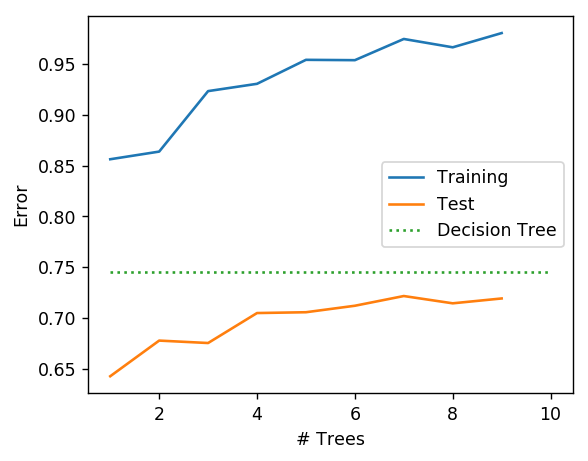

In [ ]:
%%time
n_trees = np.arange(1,10)
#n_trees = np.arange(1,26)
acc_train_rf = []
acc_test_rf = []

for n in n_trees:
    forest = RandomForest(n_trees=n)
    forest.fit(X_train, y_train)
    acc_train_rf.append(accuracy(forest, X_train, y_train))
    acc_test_rf.append(accuracy(forest, X_test, y_test))

rf_acc = np.array(acc_test_rf).max()
print('Decision Tree Accuracy: {:0.3f}'.format(dt_acc))    
print('Random Forest Accuracy: {:0.3f}'.format(rf_acc))

f, ax = plt.subplots(figsize=(5,4), dpi=125)
ax.plot(n_trees, acc_train_rf, label='Training')
ax.plot(n_trees, acc_test_rf, label='Test')
ax.plot([1, 10], [dt_acc, dt_acc], label='Decision Tree', ls=':')
#ax.plot([1, 26], [dt_acc, dt_acc], label='Decision Tree', ls=':')
ax.set_xlabel('# Trees'); ax.set_ylabel('Error'); ax.legend();

On this particular dataset, the increase in performance of the random forest classifier compared to the best version of the decision tree classifier is small (only about 2% increase in test accuracy). However, on many other datasets one will see a significant improvement in classification accuracy. Note this dataset was primarily chosen because it clearly shows overfitting as tree depth increases.

<a id='skl_rf'></a>
## 4. Random Forests in Scikit-Learn

In Python, one of the most popular machine learning libraries is scikit-learn, which has its own random forest implementation. Below is an example of its usage. We see that the scikit-learn random forest implementation and the implementation in this tutorial learn models with very similar accuracy. It is worth noting however that the scikit-learn implementation runs substantially faster, and also includes many more hyper-parameters for tuning the model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

n_trees = np.arange(1,10)
acc_test_sk = []
for n in n_trees:
    forest = RandomForestClassifier(n_estimators=n)
    forest.fit(X_train, y_train)
    acc_test_sk.append(accuracy(forest, X_test, y_test))

print('Decision Tree Accuracy: {:0.3f}'.format(dt_acc))    
print('Random Forest Accuracy: {:0.3f}'.format(rf_acc))
print('Random Forest (sklearn) Accuracy: {:0.3f}'.format(np.array(acc_test_sk).max()))

f, ax = plt.subplots(figsize=(5,4), dpi=125)
ax.plot(n_trees, acc_test_rf, label='Random Forest')
ax.plot(n_trees, acc_test_sk, label='Random Forest (sklearn)')
ax.plot([1, 26], [dt_acc, dt_acc], label='Decision Tree', ls=':'); 
ax.set_xlabel('# Trees'); ax.set_ylabel('Error'); ax.legend();

Decision Tree Accuracy: 0.746


NameError: ignored